In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing
import time
import itertools
from sklearn.cluster import KMeans
from scipy import stats
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

In [2]:
industry_df = pd.read_csv('Data/movie_industry.csv', encoding='latin-1')
oscar_df = pd.read_csv('Data/the_oscar_award.csv', encoding='latin-1')
links_df = pd.read_csv('Data/movie_lense/links.csv')
tags_df = pd.read_csv('Data/movie_lense/tags.csv')
genome_scores_df = pd.read_csv('Data/movie_lense/genome-scores.csv')
movies_df = pd.read_csv('Data/movie_lense/movies.csv')
ratings_df = pd.read_csv('Data/movie_lense/ratings.csv')
genome_tags_df = pd.read_csv('Data/movie_lense/genome-tags.csv')

In [3]:
ratings_df
userID=5
def extract_user_movies(userID,thresh=4):
    tdf = ratings_df[ratings_df['userId']==userID]
    tdf = tdf[tdf['rating']>=thresh]
    return tdf['movieId'].values

extract_user_movies(5)

array([   47,    50,   296,   318,   527,   778,   858,  1147,  1193,
        1213,  1222,  1617,  1732,  2329,  2502,  2858,  2959,  3178,
        3949,  4011,  4226,  4973,  5110,  5137,  5954,  5995,  6016,
        7361,  8784,  8873,  8949,  8950, 27831, 30749, 30820, 31410,
       32587, 33794, 38061, 40278, 44195, 44204, 46976, 48394, 48516,
       48696, 48774, 48780, 49272, 49530, 50068, 51255, 52952, 54286,
       54503, 54997, 55118, 55247, 55290, 55765, 55820, 56367, 56782],
      dtype=int64)

In [4]:
tgsdf = genome_scores_df.pivot(index='movieId',columns='tagId',values='relevance')
genome_tags_dict = dict(zip(genome_tags_df['tagId'],genome_tags_df['tag']))
movie_names_dict = dict(zip(movies_df['movieId'],movies_df['title']))
tags = genome_tags_df['tag'].values
# genome_tags_dict
# movie_names_dict
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [5]:
movie_tags_df = tgsdf.rename(genome_tags_dict,axis='columns')
movie_tags_thresh_df = movie_tags_df.copy()
thresh = 0.8
movie_tags_thresh_df[movie_tags_thresh_df<thresh] = 0
movie_tags_thresh_df[movie_tags_thresh_df>thresh] = 1
# movie_tags_df.sum()
movie_tags_df

tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0.05650,0.23175,0.04575,0.05175,0.44700,0.19875,0.04025,...,0.34725,0.03125,0.03500,0.12125,0.32200,0.08200,0.03325,0.02425,0.13725,0.02625
185585,0.04250,0.04175,0.06475,0.07625,0.08500,0.03800,0.03425,0.16850,0.02525,0.03525,...,0.04325,0.05850,0.03050,0.02750,0.21850,0.04525,0.03550,0.02550,0.17475,0.03100
186587,0.08950,0.09125,0.05075,0.04900,0.19475,0.04500,0.03125,0.17275,0.07850,0.02475,...,0.06475,0.04500,0.04000,0.01975,0.22075,0.15125,0.06150,0.04300,0.20800,0.03925


In [154]:
#make a filtered set of ratings only for the movies that have genome Data
ratings_filtered_df = ratings_df[ratings_df['movieId'].isin(movie_tags_df.index)]
print(len(ratings_df))
print(len(ratings_filtered_df))

27753444
27417362


In [6]:
# Make matrix of euclidian distance b/w each movie
dist = euclidean_distances(movie_tags_df,movie_tags_df)

In [7]:
movie_tags_df.index.get_loc(1)

0

In [8]:
np.fill_diagonal(dist,np.median(dist)) # Make all diags median so they doont influence min or max
dist

array([[5.80485434, 5.60443644, 6.33694617, ..., 6.67146577, 6.76831775,
        5.63426966],
       [5.60443644, 5.80485434, 4.9950365 , ..., 5.46353316, 7.32374549,
        5.24566639],
       [6.33694617, 4.9950365 , 5.80485434, ..., 5.31612765, 6.81545049,
        5.03226821],
       ...,
       [6.67146577, 5.46353316, 5.31612765, ..., 5.80485434, 6.3338389 ,
        5.2941725 ],
       [6.76831775, 7.32374549, 6.81545049, ..., 6.3338389 , 5.80485434,
        5.05494847],
       [5.63426966, 5.24566639, 5.03226821, ..., 5.2941725 , 5.05494847,
        5.80485434]])

In [9]:
x, y = np.unravel_index(dist.argmin(), dist.shape)

In [10]:
print(movies_df[movies_df['movieId']==movie_tags_df.index[x]])
print(movies_df[movies_df['movieId']==movie_tags_df.index[y]])

       movieId         title                 genres
13173    63436  Saw V (2008)  Crime|Horror|Thriller
       movieId          title                         genres
14456    72129  Saw VI (2009)  Crime|Horror|Mystery|Thriller


In [11]:
dist.min()

1.1689048827856068

In [12]:
x, y = np.unravel_index(dist.argmax(), dist.shape)
print(movies_df[movies_df['movieId']==movie_tags_df.index[x]])
print(movies_df[movies_df['movieId']==movie_tags_df.index[y]])

       movieId                        title       genres
21078   102062  Band Called Death, A (2012)  Documentary
       movieId                                              title  \
25628   117368  The Madagascar Penguins in a Christmas Caper (...   

                 genres  
25628  Animation|Comedy  


In [13]:
dist.max()

12.397012848363927

In [125]:
#compute average distance ignoring diagonals
weights = np.ones(dist.shape) - np.eye(dist.shape[0])
mean = np.average(dist, axis=None, weights=weights) 
mean

5.857172040426989

(array([4.7900000e+03, 1.1296360e+06, 1.7940818e+07, 5.8523690e+07,
        6.2168764e+07, 2.7129860e+07, 5.8590220e+06, 7.6918800e+05,
        7.3134000e+04, 8.0740000e+03]),
 array([ 1.16890488,  2.29171568,  3.41452648,  4.53733727,  5.66014807,
         6.78295887,  7.90576966,  9.02858046, 10.15139126, 11.27420205,
        12.39701285]),
 &lt;BarContainer object of 10 artists&gt;)

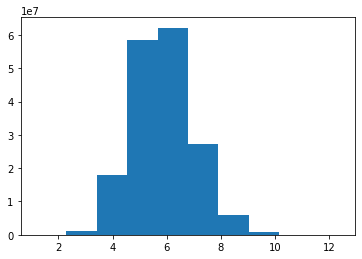

In [14]:
D = dist.flatten()
plt.hist(D)

Look at diversity metric (average pairwise euclidian distance of the recommended movies)

In [15]:
def load_evolution_df(filename):
    evolution_df = pd.read_csv(filename)
    # Clean
    evolution_df.rename({'Unnamed: 0':'Epoch','Unnamed: 1':'userId'},axis='columns',inplace=True)
    evolution_df['userId'] = [int(s.split('_')[1]) for s in evolution_df['userId'].values]
    evolution_df['Epoch'] = [int(s.split('_')[1]) for s in evolution_df['Epoch'].values]
    return evolution_df

In [16]:
evolution_df = pd.read_csv('Data/evolution_10_epochs.csv')
# Clean
evolution_df.rename({'Unnamed: 0':'Epoch','Unnamed: 1':'userId'},axis='columns',inplace=True)
evolution_df['userId'] = [int(s.split('_')[1]) for s in evolution_df['userId'].values]
evolution_df['Epoch'] = [int(s.split('_')[1]) for s in evolution_df['Epoch'].values]
evolution_df

,Epoch,userId,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
0,0,61994,2186,58559,1527,2968,4011,1201,3089,4226,1095,922,8501,1208,8477,59315,5995
1,0,220944,913,3089,2804,1036,3677,50,608,1225,1089,1090,4262,1172,1704,1213,1197
2,0,217345,260,2571,858,1225,3435,1147,31658,1196,246,5690,50,913,1213,356,2959
3,0,27622,1208,908,272,924,58,1213,4973,912,1203,2019,2973,1276,1247,750,44555
4,0,56931,1090,1213,913,750,44555,1233,2186,1228,7156,1225,1178,858,1252,1203,3435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,169602,8327,76111,1211,6858,6433,3077,1242,1274,8501,1297,3947,94959,3429,6357,97
9996,9,210038,4881,7669,8327,4327,26662,27156,140174,37741,1238,1241,86504,166643,4103,3429,899
9997,9,105962,27156,6858,1211,2925,6433,4881,3134,3429,1297,37741,3681,76111,31410,26662,97
9998,9,241194,6433,5292,3006,6357,140174,3134,7771,2925,166461,6858,98491,1211,1297,6787,3307


In [169]:
# evolution_df = load_evolution_df('Data\movie_evolution_99epochs_50users_sim_1000users_total_70mov.csv')
# evolution_df = load_evolution_df('Data\movie_evolution_99epochs_10users_sim_1000users_total_70mov.csv')
# evolution_df = load_evolution_df('Data\movie_evolution_150epochs_100users_sim_1000users_total_15mov.csv')
# evolution_df = load_evolution_df('Data\evolution_10_epochs.csv')
# evolution_df = load_evolution_df('Data\evolution_300epochs_250users_sim_1000users_total_15mov.csv')
# evolution_df = load_evolution_df('Data\evolution_400epochs_10users_sim_1000users_total_12mov.csv')
# evolution_df = load_evolution_df('Data\evolution_200epochs_10users_sim_1000users_total_15mov_best_hyperparams.csv')
# evolution_df = load_evolution_df('Data\evolution_200epochs_10users_sim_1000users_total_15mov.csv')
# evolution_df = load_evolution_df('Data\evolution_40epochs_100users_sim_1000users_total.csv')
evolution_df = load_evolution_df('Data\evolution_40epochs_100users_sim_1000users_total_100mov.csv')
evolution_df['Epoch'].max()
evolution_df

,Epoch,userId,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,...,top_91,top_92,top_93,top_94,top_95,top_96,top_97,top_98,top_99,top_100
0,0,128088,913,6016,908,3030,919,1203,55290,260,...,54286,49530,454,50685,1148,2918,3252,2731,2249,4144
1,0,267455,858,1276,1203,912,904,900,908,1201,...,1175,1208,1298,319,1212,2692,665,1230,5013,49530
2,0,73381,1203,2959,1193,1276,1200,5618,541,904,...,1266,4027,933,48516,29,1199,3730,58559,2324,1247
3,0,117628,1276,912,2959,2019,858,2324,1203,2858,...,60069,1245,1446,1089,31410,933,1256,900,935,750
4,0,21453,1148,1203,5618,1237,541,1172,50,527,...,5971,1953,778,1797,1304,38061,1175,4144,7327,1259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,39,182815,76293,108192,82169,3260,5140,64116,1484,59392,...,7562,2442,27020,7306,7307,168326,1684,59985,8362,5516
3996,39,254394,76293,108192,3260,1484,1912,99996,59392,5140,...,4664,7307,7891,110781,4844,7383,140267,165603,32291,1807
3997,39,269446,1271,115664,3182,88118,166635,95105,62956,5284,...,2267,7448,93980,157699,79588,163937,72294,25929,3118,8833
3998,39,146366,3260,89840,76293,59392,60803,82169,3845,49220,...,3933,93980,97172,1798,482,27618,135534,26819,62956,140267


In [179]:
def get_user_recommended_diversity(userID,epoch):
    tdf = evolution_df[(evolution_df['Epoch']==epoch) & (evolution_df['userId']==userID)]
    movies_list = tdf.drop(labels=['Epoch','userId'],axis=1).values[0]
    # convert to list of indices into distance matrix
    movies_list_idx = [movie_tags_df.index.get_loc(i) for i in movies_list]

    return compute_average_diversity(movies_list_idx)

def compute_average_diversity(movies_list_idx):
    tot_dist = 0
    count = 0
    if len(movies_list_idx)<=1:
        return np.nan
    for i in itertools.combinations(movies_list_idx,2):
        count += 1 
        x,y = i
        d = dist[x,y]
        tot_dist+=d
    return tot_dist/count

def get_user_initial_diversity(userID,thresh=4):
    movies_list = extract_user_movies(userID,thresh=thresh)
    print(movies_list)
    movies_list_idx = [movie_tags_df.index.get_loc(i) for i in movies_list]
    print(movies_list_idx)
    return compute_average_diversity(movies_list_idx)

# avg_diversity = get_user_recommended_diversity(128088,0)
# avg_diversity
def extract_user_movies(userID,thresh=4):
    tdf = ratings_filtered_df[ratings_filtered_df['userId']==userID]
    tdf = tdf[tdf['rating']>=thresh]
    return tdf['movieId'].values

get_user_inital_diversity(117628)
extract_user_movies(128088)
# tdf = ratings_df[ratings_df['userId']==128088]
# tdf
extract_user_movies(71789)

array([], dtype=int64)

In [180]:
unique_users = evolution_df.userId.unique()
print(len(unique_users))
unique_users

100


array([128088, 267455,  73381, 117628,  21453, 229622, 167368,  21772,
       176555, 166868,  51695, 282217, 188391, 246431,  92775, 221239,
       148267,  26118, 175652, 120855,  99370, 117610, 265869, 199247,
       128947, 194844,  58100, 131556, 167980, 205977,  99817,  16287,
       192124, 176713, 130144, 132969, 271816,  95564,  28131, 143440,
       208322,  75400,   1049, 112436, 150562, 214234, 238979, 101768,
        82109,  20804,  10839, 206194, 187884, 165585,  76559,  89916,
       200726,    244, 220558, 250894, 169755,   5275, 275947,  75629,
       114724,  33249, 247668, 194125,  63080,  69627,  30888,  71789,
       101100, 197753,  78389,  89665,  78821, 236194,  82050, 196953,
        22821,  81822,  64366, 190418, 246021,  91885, 212531, 130761,
        52391, 267242, 264440, 113299,  87939, 277092, 239551, 182815,
       254394, 269446, 146366,  88729], dtype=int64)

In [181]:
tot=0
user_diversities = []
for user in unique_users:
    print(user)
    user_diversities.append(get_user_inital_diversity(user))
avg_div = np.nanmean(user_diversities)
print(avg_div)

128088
267455
73381
117628
21453
229622
167368
21772
176555
166868
51695
282217
188391
246431
92775
221239
148267
26118
175652
120855
99370
117610
265869
199247
128947
194844
58100
131556
167980
205977
99817
16287
192124
176713
130144
132969
271816
95564
28131
143440
208322
75400
1049
112436
150562
214234
238979
101768
82109
20804
10839
206194
187884
165585
76559
89916
200726
244
220558
250894
169755
5275
275947
75629
114724
33249
247668
194125
63080
69627
30888
71789
101100
197753
78389
89665
78821
236194
82050
196953
22821
81822
64366
190418
246021
91885
212531
130761
52391
267242
264440
113299
87939
277092
239551
182815
254394
269446
146366
88729
6.74554840746035


In [182]:
# unique_users = [117610]

In [183]:
epochs = np.arange(0,evolution_df['Epoch'].max())
N = len(unique_users)
diversities = []
diversities_up = []
diversities_lo = []
for i in tqdm(epochs):
    # print("Epoch:{}".format(i))
    tot_diversity = 0
    user_diversities = []
    for user in unique_users:
        user_diversity = get_user_recommended_diversity(user,i)
        user_diversities.append(user_diversity)
        tot_diversity+=user_diversity
    diversities.append(tot_diversity/N)
    diversities_lo.append(np.percentile(user_diversities,16))
    diversities_up.append(np.percentile(user_diversities,84))

100%|██████████| 39/39 [00:16&lt;00:00,  2.37it/s]


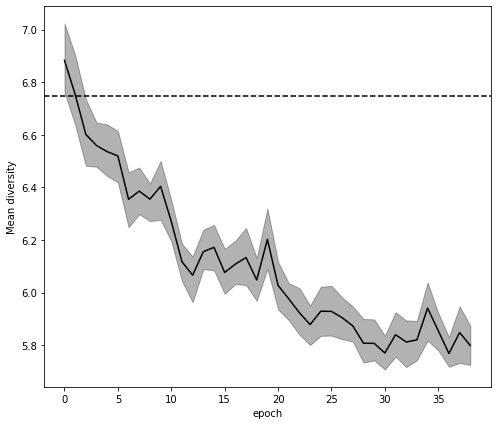

In [184]:
plt.figure(figsize=(8,7))
plt.plot(epochs,diversities,color='black')
plt.fill_between(epochs,diversities_lo,diversities_up,alpha=0.3,color='black')
plt.xlabel('epoch')
plt.ylabel('Mean diversity')
plt.axhline(avg_div,linestyle='--',color='k')
# plt.xlim(0,10)
plt.show()

What's happening to the expected rating of recommended movies over time? Is the system just running out of what it thinks are "good things" to recommend after X movies?

In [113]:
ratings_evolution_df = load_evolution_df('Data/rating_evolution_99epochs_50users_sim_1000users_total_70mov.csv')
# ratings_evolution_df = load_evolution_df('Data/rating_evolution_150epochs_100users_sim_1000users_total_15mov.csv')
ratings_evolution_df

,Epoch,userId,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,...,top_61,top_62,top_63,top_64,top_65,top_66,top_67,top_68,top_69,top_70
0,0,128088,4.834993,4.796900,4.749299,4.747827,4.735534,4.700712,4.692192,4.691138,...,4.472152,4.467850,4.466249,4.464632,4.457255,4.456105,4.455150,4.455049,4.454778,4.451519
1,0,267455,5.000000,4.930377,4.680710,4.661521,4.634999,4.596846,4.596524,4.594760,...,4.395601,4.391812,4.388240,4.388203,4.386068,4.382403,4.381654,4.381472,4.378274,4.376520
2,0,73381,4.693776,4.678485,4.671649,4.661932,4.592040,4.590338,4.575028,4.564197,...,4.369492,4.367761,4.367271,4.366297,4.366130,4.365177,4.363817,4.362803,4.361381,4.360155
3,0,117628,4.494575,4.485805,4.484073,4.483547,4.467946,4.463593,4.449251,4.445517,...,4.292762,4.292041,4.290470,4.289528,4.288464,4.288344,4.286426,4.283711,4.283129,4.282191
4,0,21453,4.626965,4.538417,4.535957,4.535554,4.524590,4.506393,4.467375,4.443697,...,4.279176,4.278874,4.273238,4.270266,4.268368,4.267676,4.267388,4.264677,4.264223,4.262697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,98,214234,3.493367,3.492661,3.490431,3.490037,3.483389,3.481675,3.481308,3.479013,...,3.459015,3.458597,3.458528,3.458493,3.458320,3.458057,3.457925,3.457645,3.457349,3.457210
4946,98,238979,3.712302,3.709723,3.708824,3.708548,3.704276,3.702192,3.702090,3.701983,...,3.684120,3.683824,3.683740,3.683706,3.682657,3.682080,3.682064,3.682008,3.681127,3.680664
4947,98,101768,3.899452,3.897176,3.896550,3.890878,3.889239,3.888048,3.887364,3.887020,...,3.863014,3.862535,3.862473,3.862412,3.862124,3.861985,3.861890,3.861811,3.861169,3.861105
4948,98,82109,4.131886,4.128281,4.128005,4.122877,4.120108,4.118594,4.113893,4.112664,...,4.085962,4.084887,4.084837,4.084719,4.084459,4.084295,4.083861,4.082992,4.082735,4.082624


In [114]:
def get_user_recommended_rating(userID,epoch):
    tdf = ratings_evolution_df[(ratings_evolution_df['Epoch']==epoch) & (ratings_evolution_df['userId']==userID)]
    ratings_list = tdf.drop(labels=['Epoch','userId'],axis=1).values[0]
    average_user_rating = np.mean(ratings_list)
    return average_user_rating

In [115]:
epochs = np.arange(0,ratings_evolution_df['Epoch'].max())
N = len(unique_users)
ratings = []
ratings_up = []
ratings_lo = []
for i in tqdm(epochs):
    print("Epoch:{}".format(i))
    tot_ratings = 0
    user_ratings = []
    for user in unique_users:
        user_rating = get_user_recommended_rating(user,i)
        user_ratings.append(user_rating)
        tot_ratings+=user_rating
    ratings.append(tot_ratings/N)
    ratings_lo.append(np.percentile(user_ratings,16))
    ratings_up.append(np.percentile(user_ratings,84))

  2%|▏         | 2/98 [00:00&lt;00:05, 16.77it/s]Epoch:0
Epoch:1
Epoch:2
  6%|▌         | 6/98 [00:00&lt;00:05, 16.59it/s]
Epoch:4
Epoch:5
Epoch:6
 10%|█         | 10/98 [00:00&lt;00:05, 16.61it/s]Epoch:7
Epoch:8
Epoch:9
Epoch:10
 14%|█▍        | 14/98 [00:00&lt;00:05, 16.49it/s]Epoch:11
Epoch:12
Epoch:13
 16%|█▋        | 16/98 [00:00&lt;00:05, 16.04it/s]
Epoch:15
Epoch:16
 18%|█▊        | 18/98 [00:01&lt;00:05, 15.72it/s]
Epoch:18
Epoch:19
 22%|██▏       | 22/98 [00:01&lt;00:04, 16.17it/s]Epoch:20
Epoch:21
Epoch:22
Epoch:23
 27%|██▋       | 26/98 [00:01&lt;00:04, 16.27it/s]Epoch:24
Epoch:25
Epoch:26
Epoch:27
 31%|███       | 30/98 [00:01&lt;00:04, 16.47it/s]Epoch:28
Epoch:29
Epoch:30
Epoch:31
 35%|███▍      | 34/98 [00:02&lt;00:03, 16.54it/s]Epoch:32
Epoch:33
Epoch:34
 37%|███▋      | 36/98 [00:02&lt;00:04, 15.28it/s]
Epoch:36
 39%|███▉      | 38/98 [00:02&lt;00:04, 13.22it/s]
Epoch:38
 43%|████▎     | 42/98 [00:02&lt;00:03, 14.27it/s]
Epoch:40
Epoch:41
Epoch:42
 45%|████▍     | 44/98

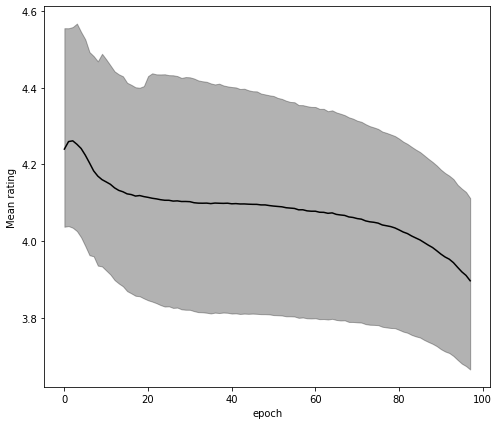

In [116]:
plt.figure(figsize=(8,7))
plt.plot(epochs,ratings,color='black')
plt.fill_between(epochs,ratings_lo,ratings_up,alpha=0.3,color='black')
plt.xlabel('epoch')
plt.ylabel('Mean rating')
plt.show()